# Obligatorio 2 - Big Data Science

Integrantes del grupo: [completar aquí los nombres de los integrantes]

Debajo de cada pregunta o tarea incluya las celdas necesarias para desarrolar la respuesta. Puede usar una o varias celdas de código o mark down (https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

Para entregar, renombrar este notebook como "Obligatorio 2 - Apellido1 - Apellido 2 - Apellido 3" con los apellidos de los miembros del grupo. Un solo integrante del grupo debe realizar la entrega. 


1. Cargar los datos del Obligatorio 1, de entrenamiento (.data) y validación (.test) en spark dataframes (distintos). Los nombres de las columnas deben corresponder a los especificados en "Attribute Information".

In [1]:
from pyspark.context import SparkContext
sc = SparkContext('local', 'test')

In [2]:
sc

<SparkContext master=local appName=test>

In [3]:
from pyspark.sql import SQLContext

spark = SQLContext(sc)

In [4]:
spark

In [5]:
from pyspark.sql.types import *

# Schema de los dataset
schema = StructType([
    StructField(name='age', dataType=IntegerType(), nullable=False),
    StructField(name='workclass', dataType=StringType(), nullable=False),
    StructField(name='fnlwgt', dataType=StringType(), nullable=False), # Se pone en tipo string porque al ponerlo en tipo Integer o Long carga la columna con valores null
    StructField(name='education', dataType=StringType(), nullable=False),
    StructField(name='education_num', dataType=StringType(), nullable=False), # Mismo problema que en la columna 'fnlwgt'
    StructField(name='marital-status', dataType=StringType(), nullable=False),
    StructField(name='occupation', dataType=StringType(), nullable=False),
    StructField(name='relationship', dataType=StringType(), nullable=False),
    StructField(name='race', dataType=StringType(), nullable=False),
    StructField(name='sex', dataType=StringType(), nullable=False),
    StructField(name='capital_gain', dataType=StringType(), nullable=False), # Mismo problema que en la columna 'fnlwgt'
    StructField(name='capital_loss', dataType=StringType(), nullable=False), # Mismo problema que en la columna 'fnlwgt'
    StructField(name='hours_per_week', dataType=StringType(), nullable=False), # Mismo problema que en la columna 'fnlwgt'
    StructField(name='native_country', dataType=StringType(), nullable=False),
    StructField(name='income', dataType=StringType(), nullable=False)
])

In [6]:
df_adult = spark.read.csv("adult.data", header=True, schema=schema)
df_test = spark.read.csv("adult.test", header=True, schema=schema) # sacamos el punto del archivo adult.test

In [7]:
df_adult.show(10)

+---+-----------------+-------+-------------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass| fnlwgt|    education|education_num|      marital-status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+-------+-------------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 50| Self-emp-not-inc|  83311|    Bachelors|           13|  Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|           0|           0|            13| United-States| <=50K|
| 38|          Private| 215646|      HS-grad|            9|            Divorced| Handlers-cleaners| Not-in-family| White|   Male|           0|           0|            40| United-States| <=50K|
| 53|          Private| 234721|    

In [8]:
df_test.show(10)

+---+-----------------+-------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass| fnlwgt|    education|education_num|     marital-status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+-------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 38|          Private|  89814|      HS-grad|            9| Married-civ-spouse|   Farming-fishing|       Husband| White|   Male|           0|           0|            50| United-States| <=50K|
| 28|        Local-gov| 336951|   Assoc-acdm|           12| Married-civ-spouse|   Protective-serv|       Husband| White|   Male|           0|           0|            40| United-States|  >50K|
| 44|          Private| 160323| Some-col

2. Seleccionar un conjunto relevante de 5 atributos y crear un Spark Pipeline en el que el estimator sea un DecisionTreeClassifier (https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier). Puede utilizar libremente los transformers/estimators de Spark para realizar ingeniería de atributos (StringIndexer, OneHotEncoding, etc).

In [9]:
atributos = ["age", "sex", "occupation", "education", "workclass"]

#Primero hay que bucketizar la edad. La separamos en 3 buckets. 

def calculo_de_buckets(df, cantidad_buckets, columna):
    df.createOrReplaceTempView("df_view")
    instancias_totales = spark.sql('''SELECT count(*) as count FROM df_view''').first()['count']
    instancias_en_bucket = instancias_totales / cantidad_buckets
    
    limites = []
    ultimo_limite_superior = None
    for limit in range(0, instancias_totales - 1, round(instancias_en_bucket)): # se pone un -1 porque instancias totales es el count pero queremos llegar hasta el indice        
        query = spark.sql(f'''SELECT {columna} FROM df_view ORDER BY 1 asc''').collect()
        limite_inferior = query[limit][columna]
        
        if(ultimo_limite_superior is not None):
            if ultimo_limite_superior == limite_inferior:
                limite_inferior += 1;
        
        limite = [limite_inferior, query[limit + round(instancias_en_bucket)][columna]]
        limites.append(limite)
        
        ultimo_limite_superior = query[limit + round(instancias_en_bucket)][columna]

    return limites

limites = calculo_de_buckets(df_adult, 3, "age")

In [10]:
from pyspark.sql import functions as F

def age_bucket_udf(age):
    indexes = range(len(limites))
    for index, limite in zip(indexes, limites):
        if age in range(limite[0], limite[1] + 1):    #Se agrega el +1 para hacer el range inclusivo superiormente
            return str(index)

age_udf = F.udf(age_bucket_udf, StringType())

df_adult_bucketized = df_adult.withColumn("ageBucket", age_udf(F.col("age")))
df_test_bucketized = df_test.withColumn("ageBucket", age_udf(F.col("age")))

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

In [12]:
def get_indexers(columnas):
    
    list_indexer = []
    
    for columna in columnas:
        list_indexer.append(StringIndexer(inputCol=columna, outputCol=columna+"Index"))
    
    return list_indexer

In [83]:
def get_pipeline(
                categoricalColumns=["sex", "occupation", "education", "workclass", "ageBucket"],
                labelCol='income',
                thresholds=None
                ):
    stages = []

    stages += get_indexers([labelCol])

    stages += get_indexers(categoricalColumns)

    assembler_input = [c + "Index" for c in categoricalColumns]

    assembler = VectorAssembler(
        inputCols=assembler_input,
        outputCol="features")

    stages += [assembler]
    
    dt = DecisionTreeClassifier(labelCol=labelCol+"Index", featuresCol="features")
    
    if thresholds:
        dt.setThresholds(thresholds)

    stages += [dt]
    
    return Pipeline(stages=stages)

In [52]:
pipeline = get_pipeline()

3. Hacer el fit del pipeline con los datos de entrenamiento. 


In [53]:
trainingData = df_adult_bucketized
testData = df_test_bucketized

In [54]:
model = pipeline.fit(trainingData)

In [ ]:
# Analisis extra

In [55]:
predictions = model.transform(testData)

In [81]:
predictions.show(10, truncate=False)

+---+-----------------+-------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+---------+-----------+--------+---------------+--------------+--------------+--------------+----------------------+----------------+----------------------------------------+----------+
|age|workclass        |fnlwgt |education    |education_num|marital-status     |occupation        |relationship  |race  |sex    |capital_gain|capital_loss|hours_per_week|native_country|income|ageBucket|incomeIndex|sexIndex|occupationIndex|educationIndex|workclassIndex|ageBucketIndex|features              |rawPrediction   |probability                             |prediction|
+---+-----------------+-------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+---------+-----------+--------+---------------+----------

In [57]:
df_ = predictions

df_.createOrReplaceTempView('df_')

df_aciertos = spark.sql("""
    SELECT income, prediction, count(*)
    FROM df_
    GROUP BY 1, 2
""")

df_aciertos.show()

+------+----------+--------+
|income|prediction|count(1)|
+------+----------+--------+
|  >50K|       1.0|    1109|
| <=50K|       1.0|     535|
| <=50K|       0.0|   11899|
|  >50K|       0.0|    2737|
+------+----------+--------+



In [58]:
# MATRIZ DE CONFUSION
import pandas as pd
pd.DataFrame([[1109, 535], [2737, 11899]], columns=['POSITIVO ACTUAL', 'NEGATIVO ACTUAL'], index = ['POSITIVO PREDECIDO', 'NEGATIVO PREDECIDO'])

,POSITIVO ACTUAL,NEGATIVO ACTUAL
POSITIVO PREDECIDO,1109,535
NEGATIVO PREDECIDO,2737,11899


4. Graficar la curva ROC utilizando los datos de validación (sin usar el paquete de evluación de Spark pyspark.ml.evaluation)

In [59]:
trainingData = df_adult_bucketized
testData = df_test_bucketized

In [143]:
def get_tpr_and_fpr(prediction):
    
    df_ = predictions

    df_.createOrReplaceTempView('df_')

    df_aciertos = spark.sql("""
        SELECT income, prediction, count(*) as count
        FROM df_
        GROUP BY 1, 2
    """)
    
    tp = df_aciertos.where('income = " >50K" and prediction = 1.0').first()['count'] if df_aciertos.where('income = " >50K" and prediction = 1.0').count() > 0 else 0
    
    fn = df_aciertos.where('income = " >50K" and prediction = "0.0"').first()['count'] if df_aciertos.where('income = " >50K" and prediction = "0.0"').count() > 0 else 0
    
    
    fp = df_aciertos.where('income = " <=50K" and prediction = 1.0').first()['count'] if df_aciertos.where('income = " <=50K" and prediction = 1.0').count() > 0 else 0
    
    
    tn = df_aciertos.where('income = " <=50K" and prediction = 0.0').first()['count'] if df_aciertos.where('income = " <=50K" and prediction = 0.0').count() > 0 else 0
    
        
    tpr = tp/(tp + fn)
    
    fpr = fp/(tn + fp)
    
    return (tpr, fpr)

In [108]:
get_tpr_and_fpr(predictions)

(1.0, 0.0)

In [144]:
thresholds = range(0, 105, 5)

values = []

for t in thresholds:
    t = t/100
    print(t)
    
    pipeline = get_pipeline(thresholds=[1-t, t])
    
    model = pipeline.fit(trainingData)
    
    predictions = model.transform(testData)
    
    tpr, fpr = get_tpr_and_fpr(predictions)
    
    values.append([t, [tpr, fpr]])    

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


In [145]:
values

[[0.0, [1.0, 1.0]],
 [0.05, [1.0, 1.0]],
 [0.1, [1.0, 1.0]],
 [0.15, [1.0, 1.0]],
 [0.2, [0.48491939677587104, 0.17588869229531928]],
 [0.25, [0.36479459178367135, 0.0657069326041499]],
 [0.3, [0.36479459178367135, 0.0657069326041499]],
 [0.35, [0.36479459178367135, 0.0657069326041499]],
 [0.4, [0.36479459178367135, 0.0657069326041499]],
 [0.45, [0.36479459178367135, 0.0657069326041499]],
 [0.5, [0.28835153406136244, 0.04302718352903329]],
 [0.55, [0.28835153406136244, 0.04302718352903329]],
 [0.6, [0.28835153406136244, 0.04302718352903329]],
 [0.65, [0.24128965158606344, 0.03112433649670259]],
 [0.7, [0.24128965158606344, 0.03112433649670259]],
 [0.75, [0.0, 0.0]],
 [0.8, [0.0, 0.0]],
 [0.85, [0.0, 0.0]],
 [0.9, [0.0, 0.0]],
 [0.95, [0.0, 0.0]],
 [1.0, [0.0, 0.0]]]

In [146]:
df = pd.DataFrame([(p,tpr,fpr) for (p,(tpr,fpr)) in values], columns=['p', 'tpr', 'fpr'])

<AxesSubplot:title={'center':'ROC (Receiver Operating Characteristic) Curve'}, xlabel='fpr'>

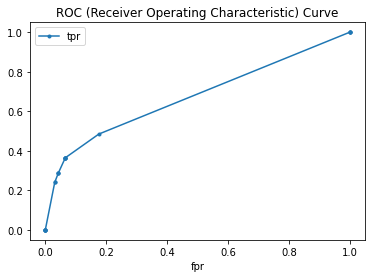

In [151]:
df.plot(style='.-',x='fpr',y='tpr', 
        title="ROC (Receiver Operating Characteristic) Curve")

5. Escribir dos funciones train() y predict() que creen el arbol de acuerdo a la metodología vista en clase (utilizando entropía como métrica de homogeneidad de clases).
```
def train(train_dataframe):
    '''
    @return devuelve una estructura de datos que representa el árbol de decision
    '''
     pass        
```

```
def predict(tree, train_dataframe)
    '''
    @param tree la estructura de datos que representa el árbol de decisión.
    @ return un dataframe con todos los datos de train_dataframe con una columna adicional que representa la probabilidad de que el income sea >50K. 
    '''
    pass
```    
Ejemplo de uso:

```
tree = train(train_dataframe)
predictions_df = predict(tree, train_dataframe)
```

In [154]:
import math
def entropy(probabs):
    return -sum([ p * math.log(p,2) for p in probabs])

In [160]:
def get_feature_entropy(df, col):
    ncol = df.select(col).distinct().collect()
    ncol = [row[col] for  row in ncol]
    
    total = df.count()
    
    prob_valor = {}
    
    entropy_valor = {}
    
    for valor in ncol:
        ntmp = df.select(col).where(f'"{col}" = "{valor}"').count()
        
        prob_valor[valor] = ntmp/total
        
        ntmp_pos = df.select(col).where(f'{col} = "{valor}" and income = " >50K"').count()
        
        prob_pos = ntmp_pos/ntmp
        
        prob_neg = 1 - prob_pos
        
        entropy = entropy([prob_pos, prob_neg])
        
        entropy_valor[valor] = entropy
    
    suma_ponderada = 0
    
    for valor in ncol:
        suma_ponderada += prob_valor[valor] * entropy_valor[valor]
    
    return suma_ponderada

In [172]:
def make_split(df, root, categorias):
    categoria_entropy = {}
    
    for categoria in categorias:
        categoria_entropy[categoria] = get_feature_entropy(df, categoria)
        
    categoria_minima = min(categoria_entropy, key=categoria_entropy.get)
    
    valores_categoria = [valores[categoria_minima] for valores in df.select(categoria_minima).distinct().collect()]
    
    for valor in valores_categoria:
        root.hijos.append({'key': valor , 'nodo': Nodo(valor=valor, padre=root)})
    
    
    
    
    

In [170]:
d = {'key0': 0, 'key1': 0, 'key2': -1}
max(d,key=d.get)

'key0'

In [171]:
class Nodo:
    def __init__(self, valor, padre, hijos=None):
        self.valor = valor
        
        if padre == 'root':
            self.padre = None
        else:
            self.padre = padre
        
        self.hijos = [] if not hijos else hijos
            

{'valor': '121', 'padre': None, 'hijos': None}

<i>[Extra credit y alumnos masters]</i>
    
5.  Mejorar la implementación de su algoritmo evitando hacer el split cuando no se logra un mínimo de Information Gain ( https://en.wikipedia.org/wiki/Information_gain_in_decision_trees   )


In [23]:
#